# DCGAN for Handling Class Imbalance

### Import Libraries 

In [1]:
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import sys
import numpy as np
import tensorflow as tf
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D, Conv2DTranspose
from keras.models import Sequential, Model
from keras.optimizers import Adam,SGD,RMSprop

### Initialization 

In [2]:
root_dir = 'D:/'
data_filename = 'sample_labels.csv'
image_dir = 'images/'

In [3]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')

In [4]:
device_name

'/device:GPU:0'

In [5]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 17269488121752597051,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 1369047040
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 3946753368218758470
 physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 960M, pci bus id: 0000:01:00.0, compute capability: 5.0"]

In [6]:
# Input shape
img_rows = 128
img_cols = 128
channels = 1
img_shape = (img_rows, img_cols, channels)
latent_dim = 100
#disc_optimizer = SGD(0.0001, 0.9)
#gen_optimizer = Adam(0.0001,0.8)
#optimizer = SGD(0.00007, 0.9)
#optimizer = SGD(0.0002, 0.5)
#optimizer = SGD(0.00009, 0.9)
#optimizer = SGD(0.00001, 0.9)
#gen_optimizer = SGD(0.00005,0.9)
#changed doubled lr and decay
lr = 1e-4
decay = 2e-8
d_optimizer = RMSprop(lr=lr, decay=decay)
g_optimizer = RMSprop(lr=lr, decay=decay)

### Generator and Discriminator  

In [7]:
def GAN_generator(latent_dim1):

    model = Sequential()
    model.add(Dense(1024 * 4 * 4, activation="relu", input_dim=latent_dim1))
    model.add(Reshape((4, 4, 1024)))
    model.add(UpSampling2D())
    model.add(Conv2DTranspose(512, kernel_size=3, strides=(1, 1), dilation_rate=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
    model.add(UpSampling2D())
    model.add(Conv2DTranspose(256, kernel_size=3, strides=(1, 1), dilation_rate=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
    model.add(UpSampling2D())
    model.add(Conv2DTranspose(128, kernel_size=3, strides=(1, 1), dilation_rate=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
    model.add(UpSampling2D())
    model.add(Conv2DTranspose(64, kernel_size=3, strides=(1, 1), dilation_rate=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
    model.add(UpSampling2D())
    model.add(Conv2DTranspose(128, kernel_size=3, strides=(1, 1), dilation_rate=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
    model.add(Conv2DTranspose(1, kernel_size=3, strides=(1, 1), dilation_rate=2, padding="same"))
    model.add(Activation("tanh"))

    model.summary()
    noise = Input(shape=(latent_dim,))
    img = model(noise)
    return Model(noise, img)

In [8]:
def GAN_discriminator(img_shape1):

    model = Sequential()
    model.add(Conv2D(32, kernel_size=3, strides=(2, 2), input_shape=img_shape1, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Conv2D(64, kernel_size=3, strides=(2, 2), padding="same"))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Conv2D(128, kernel_size=3, strides=(2, 2), padding="same"))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Conv2D(256, kernel_size=3, strides=(2, 2), padding="same"))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Conv2D(256, kernel_size=3, strides=(2, 2), padding="same"))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    model.summary()
    img = Input(shape=img_shape1)
    Class_ = model(img)
    return Model(img, class_)

### Loading the DCGAN models 

In [9]:
discriminator = GAN_discriminator(img_shape) 
discriminator.compile(loss='binary_crossentropy',
                      optimizer=d_optimizer, metrics=['accuracy'])

generator = GAN_generator(latent_dim) 

z = Input(shape=(latent_dim,))
img = generator(z)

discriminator.trainable = False
valid = discriminator(img)

dcgan = Model(z, valid)
dcgan.compile(loss='binary_crossentropy', optimizer=g_optimizer)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        320       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 64, 64, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 64)        256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 64)        0

In [10]:
class PlotLosses(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show();
        
plot_losses = PlotLosses()

### Load NIH chest x-ray images 

In [11]:
def nih_xrays(epochs, batch_size):
    (img_x, img_y) = 128, 128
    train_path = root_dir+data_filename

    class_name = 'Fibrosis' #['Atelectasis', 'No Finding', 'Cardiomegaly', 'Effusion', 'Pneumothorax']
    num_classes = 14
    dataTrain = pd.read_csv(train_path)
    
    x_train = []
    # prepare label binarizer
    from sklearn import preprocessing
    image_path = root_dir+image_dir

    count = 0
    for index, row in dataTrain[dataTrain["Finding Labels"] == class_name].iterrows():
        #print('index,row',row["Image Index"])
        img1 = image_path + row["Image Index"]
        image1 = cv2.imread(img1)  # Image.open(img).convert('L')
        #print('image 1',image1.shape)
        image1 = image1[:, :, 0]
        #print('image 1',image1.shape)
        arr1 = cv2.resize(image1, (img_x, img_y))
        arr1 = arr1.astype('float32')
        arr1 /= 255.0
        arr1 = arr1 - np.mean(arr1)
        x_train.append(arr1)
        count += 1

    print("shape of x train: {}".format(len(x_train)))
    x_train = np.asarray(x_train)

    x_train = x_train.reshape(count, img_y, img_x, 1)

    valid1 = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for epoch in range(epochs):
        idx = np.random.randint(0, x_train.shape[0], batch_size)
        imgs = x_train[idx]
        #print('img shape',imgs.shape)

        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        gen_imgs = generator.predict(noise)

        # Train the discriminator 
        d_loss_real = discriminator.train_on_batch(imgs, valid1)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        # Train the generator 
        g_loss = dcgan.train_on_batch(noise, valid1)

        # Plot the progress
        print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100 * d_loss[1], g_loss))

### Train Generator and Discriminator 

shape of x train: 727
0 [D loss: 0.895362, acc.: 43.75%] [G loss: 0.707890]
1 [D loss: 0.692845, acc.: 65.62%] [G loss: 0.691535]
2 [D loss: 0.542892, acc.: 71.88%] [G loss: 0.698175]
3 [D loss: 0.510967, acc.: 75.00%] [G loss: 0.702067]
4 [D loss: 0.212927, acc.: 96.88%] [G loss: 0.698601]
5 [D loss: 0.281558, acc.: 93.75%] [G loss: 0.683465]
6 [D loss: 0.179111, acc.: 96.88%] [G loss: 0.683813]
7 [D loss: 0.248005, acc.: 96.88%] [G loss: 0.684265]
8 [D loss: 0.166904, acc.: 100.00%] [G loss: 0.681060]
9 [D loss: 0.327075, acc.: 90.62%] [G loss: 0.683312]
10 [D loss: 0.281732, acc.: 96.88%] [G loss: 0.698775]
11 [D loss: 0.369046, acc.: 81.25%] [G loss: 0.698154]
12 [D loss: 0.380799, acc.: 81.25%] [G loss: 0.699547]
13 [D loss: 0.341439, acc.: 90.62%] [G loss: 0.706923]
14 [D loss: 0.299694, acc.: 87.50%] [G loss: 0.690020]
15 [D loss: 0.556298, acc.: 71.88%] [G loss: 0.714306]
16 [D loss: 0.296061, acc.: 90.62%] [G loss: 0.703860]
17 [D loss: 0.590851, acc.: 78.12%] [G loss: 0.71798

FileNotFoundError: [Errno 2] No such file or directory: '/home/kimberly/deep_learning/datasets/NIH_chest_xrays/GAN/Fibrosis/ClassFib0-0.png'

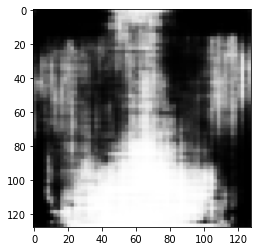

In [12]:
with tf.device('/gpu:0'):
  if __name__ == '__main__':
    epochs=100
    batch_size=16
    nih_xrays(epochs, batch_size)
    
    generator.save('saved_models/GAN_fib.h5')
    discriminator.save('saved_models/GAN_fib.h5')

    from sklearn import preprocessing

    lb = preprocessing.LabelEncoder()  
    #classes =['Cardiomegaly','Emphysema','Effusion','Hernia','Nodule','Pneumothorax','Atelectasis','Pleural_Thickening','Mass','Edema','Consolidation','Infiltration','Fibrosis','Pneumonia']
    classes =['Fibrosis']
    b_labels = lb.fit_transform(classes)
    #print('ohe labels',OHE_labels)
    # at the end, loop per class, per 1000 images
    cnt = 0
    fig, ax = plt.subplots()
    for label in b_labels:
        for num in range(100):
            noise1 = np.random.normal(0, 1, (16, latent_dim))  
            #print('noise 1',noise1)
            img = generator.predict(noise1)
            plt.imshow(img[cnt, :, :, 0], cmap='gray')
            fig.savefig(root_dir+"GAN/Fibrosis/ClassFib" + str(label) + "-" + str(num) + ".png")
            plt.clf()
